In [1]:
import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.26.0


# ESML - accelerator: Quick 3 step DEMO
- 1) `AutoMap datalake` & init ESML project
- 2) `Train model & compare` scoring to existing active model in DEV, TEST, or PROD
- 3) `Deploy model & Test` AKS webservice




Uses `ESML accelerators` & factories, to `code faster` to abstract away `Azure ML Studio` (datasets/versioning/experiments) automated createion, and adds `NEW` concepts.
- EMSL enables `enterprise CONCEPTS` (Project/Model/Dev_Test_Prod)` - able to scale across Azure subscriptions in DEV, TEST, PROD for a model.
- ESML includes `accelerators for data refinement, with CONCEPTS`: Bronze, Silver, Gold, able to `share refined data ACROSS projects` & models
- ESML includes `accelerators for ML CONCEPTS` such as `Split to TRAIN,VALIDATE, TEST` (X_test, y_test to auto-generate charting)
![](./images/split_gold_and_train_automl_small.png)

# 1) `ESML - Autolake-mapping` generates Azure ML Datasets + Feature engineering: `Bronze->Silver->Gold`

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.active_model = 11
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.inference_mode = False

unregister_all_datasets=False
if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose

p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [4]:
def before_feature_engieering():
    p.connect_to_lake()
    esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
    df_bronze = esml_dataset.InData.to_pandas_dataframe()
    return df_bronze
before_feature_engieering().head()

Using GEN2 as Datastore


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
def test_feature_engieering():
    # Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
    esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    esml_dataset2 = p.DatasetByName("ds02_other") # Get dataset
    df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

    df = esml_dataset.Silver.to_pandas_dataframe() 
    df_filtered = df[df.AGE > 0.015] 
    gold = p.save_gold(df_filtered)  #Silver -> Gold
    return gold

In [6]:
datastore = None
gold = None
gold_train = None
try:
    datastore = p.connect_to_lake()
    gold = p.Gold
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

Using GEN2 as Datastore
1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets
...
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  2021/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)

Inference mode (False = Training mode): False
Load data as Datasets....
ds01_diabetes
...
ds02_other
...

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN, _BRONZE, _

In [ ]:
datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
gold = test_feature_engieering()

In [7]:
gold.to_pandas_dataframe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
2,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0
3,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,110.0
4,0.027178,0.050680,0.017506,-0.033214,-0.007073,0.045972,-0.065491,0.071210,-0.096433,-0.059067,69.0
...,...,...,...,...,...,...,...,...,...,...,...
180,0.048974,0.050680,0.088642,0.087287,0.035582,0.021546,-0.024993,0.034309,0.066048,0.131470,310.0
181,0.070769,0.050680,-0.030996,0.021872,-0.037344,-0.047034,0.033914,-0.039493,-0.014956,-0.001078,66.0
182,0.016281,-0.044642,0.001339,0.008101,0.005311,0.010899,0.030232,-0.039493,-0.045421,0.032059,49.0
183,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

# 2) `ESML` Train model in `5 codelines`

In [2]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

label = p.active_model["label"]
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # 3) Auto-registerin AZURE (M03_GOLD_TRAIN | M03_GOLD_VALIDATE | M03_GOLD_TEST)          # Alt: p.Gold.random_split(percentage=0.8, seed=23)

automl_config = AutoMLConfig(task = 'regression', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_regression.MAE, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.308', # DEMO purpose
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False
# Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster prj02-m11-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = prj02-m11-dev


AttributeError: 'NoneType' object has no attribute 'upload'

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

## 2b) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [2]:
from baselayer_azure_ml import AutoMLFactory
target_env = p.dev_test_prod #"dev", test, prod  = Target environment. Does Model A score better than Model B?
print("SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD \n")

promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env)

print("New Model: {} in environment {}".format(m1_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(m2_name,target_env))

if (promote and p.dev_test_prod == target_env): # Can register a model in same workspace (test->test) - need to retrain if going from dev->test (but copy from test->prod) AutoML7d5ab21270
    AutoMLFactory(p).register_active_model(target_env)


SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD 

Loading AutoML config settings from: dev
targe=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)



Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
found model via REMOTE FILTER: Experiment TAGS: model name and version


Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


target - best_run_id AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140
target - best_run_id (best run) AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140_0

target - model_name (from model.tag) AutoML08bb87d490
target - model_version 1
target_best_run_id AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140
New trained model & cached RUN, has TASK_TYPE: regression and Best_Run_id: AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27_0
Target model & RUN, in Azure ML Studio workspace to compare with, has TASK_TYPE: regression and Best_Run_id:AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140_0 

Q: Do we have SCORING DRIFT / CONCEPT DRIFT?
Q: Is a model trained on NEW data better? Is the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
A: - Lets check. Instead of DataDrift, lets look at actual SCORING on new data (or same data, other code). See if we should PROMOTE newly trained model...

New trained model: 
RMSE (normalized_root_mean_squared_error): 0.03849534182426531
MAPE (M

# TEST SET SCORING

In [5]:
try:
    p.GoldTest.name
except: 
    p.connect_to_lake()
    train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,p.active_model["label"]) 

found model via REMOTE FILTER: Experiment TAGS: model name and version


Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


Replacing tag run_id -> AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140 with run_id -> AutoML_08bb87d4-9587-4b99-b781-fe16bd13f140
Replacing tag model_name -> AutoML08bb87d490 with model_name -> AutoML08bb87d490
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag test_set_RMSE -> 57.169434 with test_set_RMSE -> 57.169434
Replacing tag test_set_R2 -> 0.319053 with test_set_R2 -> 0.319053
Replacing tag test_set_MAPE -> 0.272946 with test_set_MAPE -> 0.272946
Replacing tag test_set_Spearman_Correlation -> 0.596206 with test_set_Spearman_Correlation -> 0.596206
Model tag add operation complete.
RMSE:
57.16943442166354

R2:
0.3190528794944473

MAPE:
0.2729455667922768

MAE:
45.35322553078156

Spearman:
0.5962062875330425


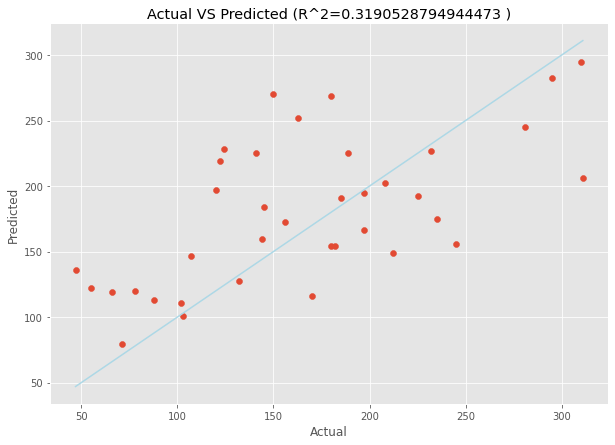

In [6]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from baselayer_azure_ml import ESMLTestScoringFactory

label = p.active_model["label"]
rmse, r2, mean_abs_percent_error,mae,spearman_corr,plt = ESMLTestScoringFactory(p).get_test_scoring_4_regression(label)
print("RMSE:")
print(rmse)
print()
print("R2:")
print(r2)
print()
print("MAPE:")
print(mean_abs_percent_error)
print()
print("MAE:")
print(mae)
print()
print("Spearman:")
print(spearman_corr)

# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [11]:
p.dev_test_prod,p.ws.name

('dev', 'msft-weu-DEV-eap-proj02_ai-amls')

In [12]:
inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,True) # True=Overwrite. Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Loading AutoML config settings from: dev
Loading AutoML config settings from: dev


Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


Deploying model: AutoML08bb87d490 with verison: 1 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m11-dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since not supported) for environment dev
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-09-30 23:58:37+02:00 Creating Container Registry if not exists.
2021-09-30

## 3b) ESML Test AKS webservice, `2 lines of code`

In [14]:
p.inference_mode = True # We want "SCORING" mode

In [15]:
#p.connect_to_lake() # only needed if NOT p.init() is done
X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)
print(tags)
caller_id = "91965d9c-40ca-4e47-9723-5a608a32a0e4"

df = p.call_webservice(p.ws, X_test,caller_id) # Auto-fetch key from keyvault, and calls the webservice
df.head()

M11_GOLD_VALIDATE : (37, 11)
X_test  (37, 10)
y_test  (37,)
{'split_percentage': '0.2', 'label': 'Y', 'model': '11_diabetes_model_reg'}
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
Saved SCORED data in LAKE, as file 'scored_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,result
0,0.05,0.05,0.12,0.08,-0.10,-0.10,-0.07,-0.00,0.04,-0.03,243.13
1,0.07,-0.04,0.07,0.04,0.02,0.00,-0.04,0.04,0.08,0.11,293.24
2,0.06,0.05,-0.03,0.01,0.02,0.02,0.03,-0.04,-0.03,-0.06,94.01
3,0.02,-0.04,0.02,-0.02,0.06,0.04,0.03,-0.00,0.04,-0.00,148.81
4,0.02,-0.04,0.11,0.06,0.01,-0.03,-0.02,0.02,0.10,0.02,253.00


# From "OFFILINE": Test Scoring, without train, deploy, or ESMLProject.init()

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = True # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

label = "Y"
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")

        AGE       SEX       BMI        BP        S1        S2        S3  \
0  0.041708 -0.044642 -0.007284  0.028758 -0.042848 -0.048286  0.052322   
1  0.059871  0.050680  0.022895  0.049415  0.016318  0.011838 -0.013948   
2  0.041708  0.050680  0.071397  0.008101  0.038334  0.015909 -0.017629   
3  0.041708  0.050680  0.012117  0.039087  0.054845  0.044406  0.004460   
4  0.034443  0.050680  0.028284 -0.033214 -0.045599 -0.009769 -0.050764   

         S4        S5        S6  
0 -0.076395 -0.072128  0.023775  
1 -0.002592  0.039540  0.019633  
2  0.034309  0.073410  0.085907  
3 -0.002592  0.045601 -0.001078  
4 -0.002592 -0.059473 -0.021788  


In [2]:
p.connect_to_lake() # only needed if NOT p.init() is done
caller_id = "91965d9c-40ca-4e47-9723-5a608a32a0e4"
df = p.call_webservice(p.ws, to_score,caller_id) # Auto-fetch key from keyvault, and calls the webservice
df.head()

Using GEN2 as Datastore
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
Saved SCORED data in LAKE, as file 'scored_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,result
0,0.041708,-0.044642,-0.007284,0.028758,-0.042848,-0.048286,0.052322,-0.076395,-0.072128,0.023775,154.320413
1,0.059871,0.050680,0.022895,0.049415,0.016318,0.011838,-0.013948,-0.002592,0.039540,0.019633,226.793287
2,0.041708,0.050680,0.071397,0.008101,0.038334,0.015909,-0.017629,0.034309,0.073410,0.085907,280.466728
3,0.041708,0.050680,0.012117,0.039087,0.054845,0.044406,0.004460,-0.002592,0.045601,-0.001078,174.478831
4,0.034443,0.050680,0.028284,-0.033214,-0.045599,-0.009769,-0.050764,-0.002592,-0.059473,-0.021788,183.854316


# END